In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta

import pandas as pd
import numpy as np


import os
os.chdir("../")
from Sources.tools import *

# Load data

In [2]:
df_technical = get_technical_df()
df_fundamental = get_fundamental_df()

# Pre process data

## Technical data

In [3]:
# Add technical indicators
df_technical = add_technical_indicators(df_technical)

# Scale with MinMaxScaler
df_technical_new = scale_df(df_technical, ["Date", "Name"])

technical_indicators = ["Close","Volume","ATR","RSI","Average","MA40","MA80","MA160"]

In [4]:
# Create windows for LSTM
windows_df = create_windows_dataframe(df_technical_new, technical_indicators)

# Filter year to correspond to fundamental data
filtered_windows_df = filter_actions_complete_years(windows_df)

# Print infos
len_tot = len(filtered_windows_df)
actions_nb = len(np.unique(filtered_windows_df["Name"]))
print(f"Total : {len_tot} données\nActions : {actions_nb}\nVaribales techniques : {len(technical_indicators)}")

Total : 465 données
Actions : 93
Varibales techniques : 8


In [5]:
filtered_windows_df

,Name,year,tech_window,target_window
0,AAPL,2017,"[[0.0071935744708795666, 0.05876029639584944, ...","[0.007609039732894484, 0.007600328043729652, 0..."
1,AAPL,2018,"[[0.01129126573187446, 0.05026586950119033, 0....","[0.01136899710769603, 0.01136698687519626, 0.0..."
2,AAPL,2019,"[[0.012652248349151799, 0.09883859525634797, 0...","[0.010408067117853081, 0.009353992606358668, 0..."
3,AAPL,2020,"[[0.017724271490821033, 0.046094254220366, 0.0...","[0.01995236983962284, 0.019756698347989335, 0...."
4,AAPL,2021,"[[0.03146275867857223, 0.040575322249146464, 0...","[0.034513076884737766, 0.03494194148133726, 0...."
...,...,...,...,...
460,XLNX,2017,"[[0.014096324325581739, 0.0013425851595801803,...","[0.01565900810949317, 0.015543750007845481, 0...."
461,XLNX,2018,"[[0.019304377630563405, 0.0006723558451417811,...","[0.018020456652440623, 0.01838499380904739, 0...."
462,XLNX,2019,"[[0.02355016249486682, 0.0023456165290978515, ...","[0.023105211948274237, 0.022228715813416646, 0..."
463,XLNX,2020,"[[0.02458748336469858, 0.0014973434315188002, ...","[0.027072232984290276, 0.02644501385939431, 0...."


## Fundamental data

In [6]:
# Create Fundamental DataFrame
df_transformed = transform_fundamentals(df_fundamental)
df_transformed.rename(columns={'symbol': 'Name'}, inplace=True)
fund_features = df_transformed.columns.tolist()[2:]

# Remove NaN
df_cleaned = fill_missing_values(df_transformed)
df_filled = fill_nan_with_yearly_mean(df_cleaned)

# Scaling
df_fundamental = scale_df(df_filled, ["Name", "year"])

d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:254: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df_filled.groupby("Name").apply(lambda group: group.interpolate(method='linear').ffill().bfill())
d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:254: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df_filled.groupby("Name").apply(lambda group: group.interpolate(method='linear').ffill().bfill())
d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:254: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. C

In [7]:
df_fundamental

,Name,year,asset_turnover,buyback_yield,capex_to_revenue,cash_ratio,cash_to_debt,cogs_to_revenue,current_ratio,days_inventory,...,price_to_earnings_ratio,price_to_earnings_ratio_nri,price_to_free_cashflow,price_to_operating_cashflow,rate_of_return,scaled_net_operating_assets,yoy_ebitda_growth,yoy_eps_growth,yoy_revenue_growth,zscore
0,AAPL,2017,0.175676,0.5812,0.000346,0.046203,0.001004,0.105448,0.068266,0.009785,...,0.015327,0.013848,0.010395,0.011471,0.786899,0.454208,0.447816,0.322853,0.123041,0.185993
1,AAPL,2018,0.191892,0.6336,0.000346,0.035443,0.000908,0.105448,0.059041,0.010737,...,0.017838,0.016363,0.012635,0.013986,0.752333,0.436881,0.454380,0.336009,0.135558,0.196551
2,AAPL,2019,0.197297,0.6322,0.000260,0.059494,0.001466,0.105448,0.084256,0.009846,...,0.017736,0.016260,0.012726,0.014520,0.689423,0.419554,0.442448,0.314940,0.115809,0.196903
3,AAPL,2020,0.221622,0.5722,0.000173,0.053797,0.001275,0.105448,0.073186,0.009480,...,0.036437,0.034990,0.024088,0.027426,0.622019,0.418317,0.444965,0.322577,0.123766,0.233679
4,AAPL,2021,0.289189,0.5724,0.000173,0.031013,0.000781,0.098418,0.055351,0.009883,...,0.024973,0.023509,0.021813,0.024606,0.733149,0.434406,0.479591,0.365508,0.155887,0.245293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,ZS,2018,0.159459,0.4040,0.000606,0.102532,0.002391,0.031634,0.119926,0.102929,...,0.055278,0.054033,0.416693,0.160988,0.736833,0.346535,0.415498,0.283422,0.285193,0.339609
503,ZS,2019,0.154054,0.4040,0.000779,0.087342,0.002391,0.031634,0.105781,0.109755,...,0.064239,0.063067,0.416693,0.223234,0.719860,0.370050,0.484083,0.360159,0.087957,0.510470
504,ZS,2020,0.091892,0.4040,0.000952,0.203797,0.002391,0.035149,0.218942,0.105302,...,0.086953,0.085258,0.685936,0.264558,0.684191,0.389851,0.179681,0.111890,0.152948,0.266761
505,ZS,2021,0.086486,0.4040,0.000692,0.131646,0.002470,0.035149,0.147601,0.098047,...,0.064179,0.065005,0.245735,0.196735,0.664562,0.384901,0.384985,0.232401,0.168332,0.326060


## Merge

In [8]:
df_all = pd.merge(filtered_windows_df, df_fundamental, how="inner", on=["Name", "year"])

In [9]:
df_all

,Name,year,tech_window,target_window,asset_turnover,buyback_yield,capex_to_revenue,cash_ratio,cash_to_debt,cogs_to_revenue,...,price_to_earnings_ratio,price_to_earnings_ratio_nri,price_to_free_cashflow,price_to_operating_cashflow,rate_of_return,scaled_net_operating_assets,yoy_ebitda_growth,yoy_eps_growth,yoy_revenue_growth,zscore
0,AAPL,2017,"[[0.0071935744708795666, 0.05876029639584944, ...","[0.007609039732894484, 0.007600328043729652, 0...",0.175676,0.5812,0.000346,0.046203,0.001004,0.105448,...,0.015327,0.013848,0.010395,0.011471,0.786899,0.454208,0.447816,0.322853,0.123041,0.185993
1,AAPL,2018,"[[0.01129126573187446, 0.05026586950119033, 0....","[0.01136899710769603, 0.01136698687519626, 0.0...",0.191892,0.6336,0.000346,0.035443,0.000908,0.105448,...,0.017838,0.016363,0.012635,0.013986,0.752333,0.436881,0.454380,0.336009,0.135558,0.196551
2,AAPL,2019,"[[0.012652248349151799, 0.09883859525634797, 0...","[0.010408067117853081, 0.009353992606358668, 0...",0.197297,0.6322,0.000260,0.059494,0.001466,0.105448,...,0.017736,0.016260,0.012726,0.014520,0.689423,0.419554,0.442448,0.314940,0.115809,0.196903
3,AAPL,2020,"[[0.017724271490821033, 0.046094254220366, 0.0...","[0.01995236983962284, 0.019756698347989335, 0....",0.221622,0.5722,0.000173,0.053797,0.001275,0.105448,...,0.036437,0.034990,0.024088,0.027426,0.622019,0.418317,0.444965,0.322577,0.123766,0.233679
4,AAPL,2021,"[[0.03146275867857223, 0.040575322249146464, 0...","[0.034513076884737766, 0.03494194148133726, 0....",0.289189,0.5724,0.000173,0.031013,0.000781,0.098418,...,0.024973,0.023509,0.021813,0.024606,0.733149,0.434406,0.479591,0.365508,0.155887,0.245293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,XEL,2017,"[[0.010279407125373998, 0.0012538556659815695,...","[0.010713634727803248, 0.010761882352795245, 0...",0.070270,0.4996,0.002336,0.000633,0.000000,0.101933,...,0.020610,0.019139,0.040565,0.005412,0.510716,0.467822,0.444638,0.316463,0.112568,0.140243
406,XEL,2018,"[[0.013544157629839283, 0.0012721969932982385,...","[0.012640856690820178, 0.01255508336250079, 0....",0.067568,0.4814,0.002855,0.001266,0.000000,0.103691,...,0.018985,0.017512,0.056090,0.005704,0.521604,0.470297,0.440971,0.322109,0.110258,0.139187
407,XEL,2019,"[[0.013595085223998068, 0.0035330712738663203,...","[0.012750753831635566, 0.012699825214978056, 0...",0.062162,0.4718,0.003115,0.002532,0.000000,0.100176,...,0.023644,0.022177,0.060716,0.008321,0.512271,0.476485,0.444534,0.320055,0.107150,0.140243
408,XEL,2020,"[[0.016144164328579933, 0.001776131606732171, ...","[0.016546227188514093, 0.01662663955600118, 0....",0.056757,0.4588,0.003980,0.001266,0.000000,0.096661,...,0.023473,0.022007,0.085139,0.011166,0.455928,0.476485,0.443913,0.319205,0.107464,0.140419


# Split data

In [10]:
tech_features = len(technical_indicators)  # Si `tech_window` ne contient que le prix de clôture

train_years = [2017, 2018, 2019]
val_years = [2020]
test_years = [2021]

df_train, df_val, df_test = split_data_by_year(df_all, train_years, val_years, test_years)

# Préparer les entrées/sorties
X_train_tech, X_train_fund, y_train = prepare_model_inputs(df_train, tech_features, fund_features)
X_val_tech, X_val_fund, y_val = prepare_model_inputs(df_val, tech_features, fund_features)
X_test_tech, X_test_fund, y_test = prepare_model_inputs(df_test, tech_features, fund_features)

# Model

In [16]:
# Paramètres d'exemple
timesteps = 30           # par exemple, 30 jours de données techniques
n_tech_features = len(technical_indicators)     # nombre de caractéristiques techniques (prix, indicateurs, etc.)
n_fund_features = len(fund_features)     # nombre de ratios fondamentaux

# --- Branche technique ---
tech_input = Input(shape=(timesteps, n_tech_features), name='tech_input')
tech_lstm = LSTM(64, return_sequences=True)(tech_input)  # retourne une séquence

# --- Branche fondamentale ---
fund_input = Input(shape=(n_fund_features,), name='fund_input')
fund_dense = Dense(32, activation='relu')(fund_input)
fund_dense = Dense(16, activation='relu')(fund_dense)
# Répéter les caractéristiques fondamentales pour chaque jour de la séquence
fund_repeated = RepeatVector(timesteps)(fund_dense)

# --- Fusion des branches ---
combined = Concatenate(axis=-1)([tech_lstm, fund_repeated])

# # --- Prédiction finale ---
# # On peut passer le résultat fusionné dans une nouvelle LSTM pour capturer des dynamiques sur la séquence enrichie
# final_lstm = LSTM(32, return_sequences=True)(combined)
# output = TimeDistributed(Dense(1, activation='linear'))(final_lstm)

# --- Prédiction finale ---
final_lstm = LSTM(32, return_sequences=False)(combined)  # Pas de séquence, juste un vecteur
output = Dense(3, activation='linear')(final_lstm)  # Prédire 3 valeurs directement

# Définition et compilation du modèle
model = Model(inputs=[tech_input, fund_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=["mse"])

# Affichage de la structure du modèle
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fund_input          │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,280 │ fund_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 30, 64)    │     18,688 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 30, 16)    │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30, 80)    │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     14,464 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │         99 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,059 (136.95 KB)

 Trainable params: 35,059 (136.95 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = model.fit([X_train_tech, X_train_fund], y_train, 
          validation_data=([X_val_tech, X_val_fund], y_val),
          epochs=100, batch_size=32)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.0202e-04 - mse: 6.0202e-04 - val_loss: 2.1424e-04 - val_mse: 2.1424e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3420e-04 - mse: 2.3420e-04 - val_loss: 6.5253e-04 - val_mse: 6.5253e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0352e-04 - mse: 2.0352e-04 - val_loss: 4.2386e-04 - val_mse: 4.2386e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3945e-04 - mse: 1.3945e-04 - val_loss: 2.4834e-04 - val_mse: 2.4834e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0699e-04 - mse: 1.0699e-04 - val_loss: 1.7665e-04 - val_mse: 1.7665e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.8186e-05 - mse: 7.8186e-05 - val_loss: 1.9958e-0

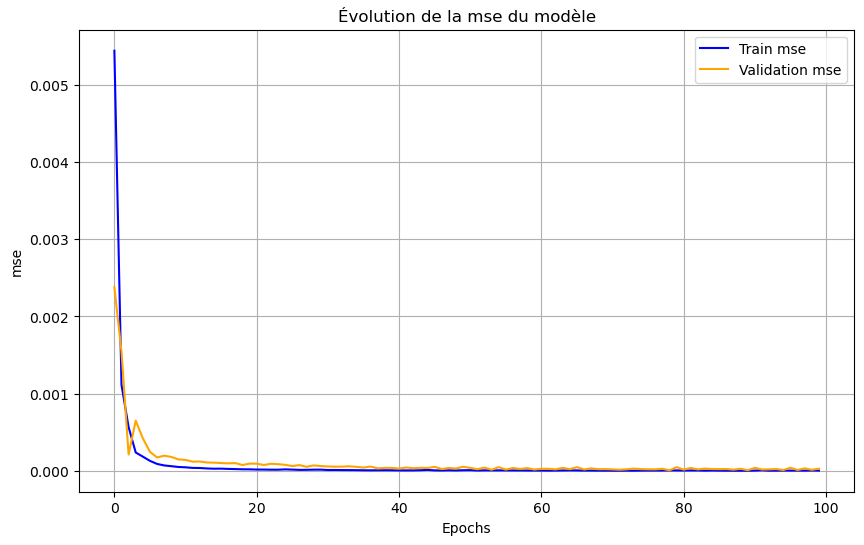

In [18]:
plot_training_curves(history, "mse")

## Train

In [19]:
y_pred_train = model.predict([X_train_tech, X_train_fund])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [20]:
get_performance_metrics_multiple_days(y_train, y_pred_train)

{'Day 1': {'RMSE': 0.0026779762040265867,
  'MAE': 0.00233984707017696,
  'R²': 0.9985593675708455,
  'NMAE': 0.05488907477428773,
  'Accuracy': 100.0,
  'MAPE': 14.185991563391475,
  'SMAPE': 16.374113453816058},
 'Day 2': {'RMSE': 0.0027621152196741863,
  'MAE': 0.0018652155979558323,
  'R²': 0.9984566800065736,
  'NMAE': 0.04390540119329881,
  'Accuracy': 100.0,
  'MAPE': 8.523096870626254,
  'SMAPE': 9.89996455158694},
 'Day 3': {'RMSE': 0.0033418409014197964,
  'MAE': 0.0021236102949480783,
  'R²': 0.9978255032245101,
  'NMAE': 0.04908027213904984,
  'Accuracy': 100.0,
  'MAPE': 7.682063115039557,
  'SMAPE': 8.307335001278085}}

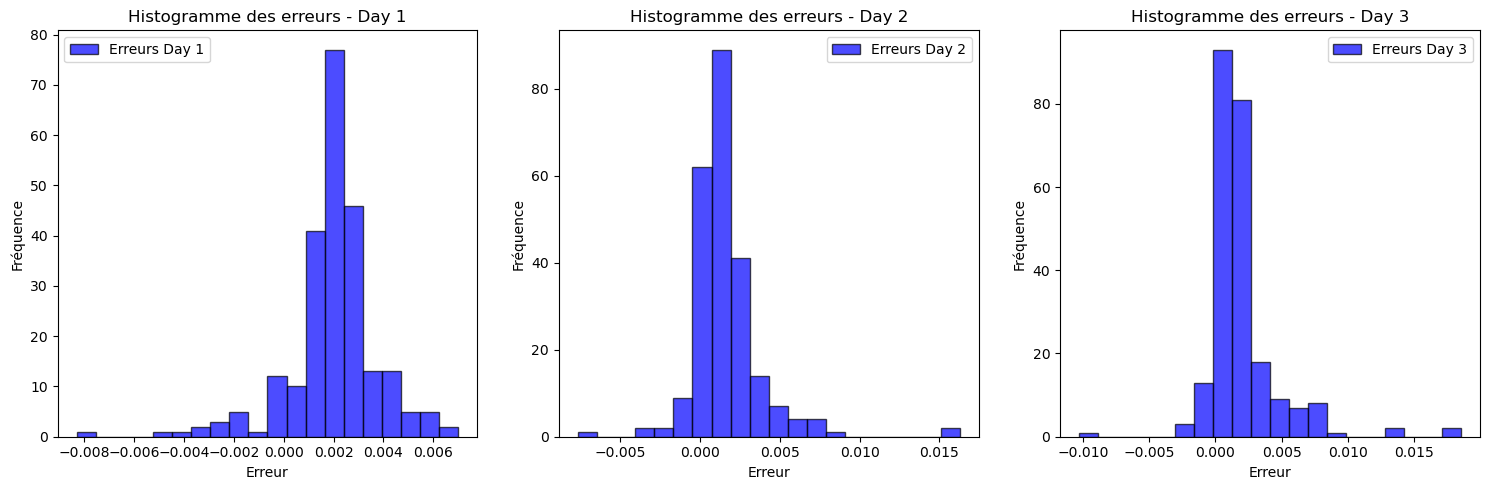

In [21]:
plot_errors_hist_multiple_days(y_train, y_pred_train)

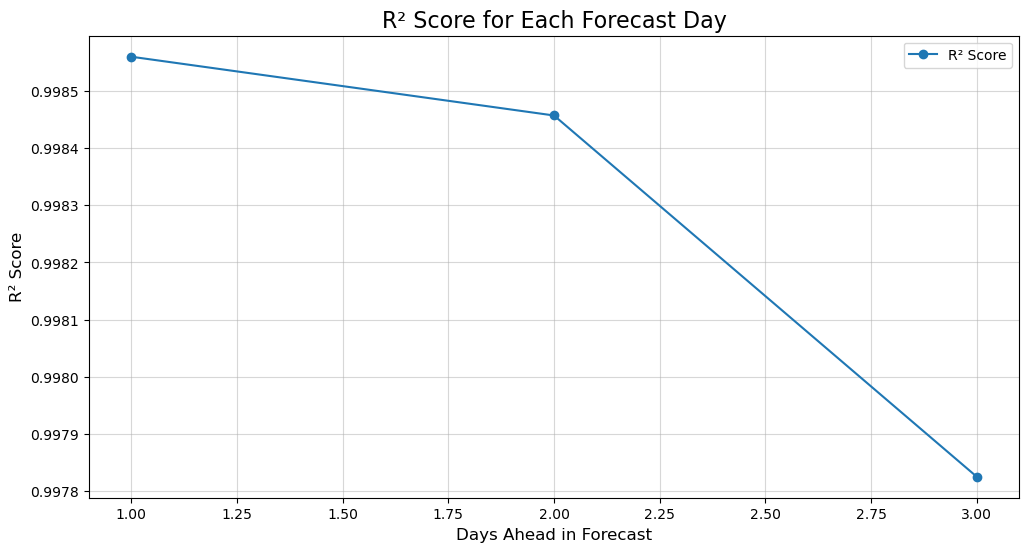

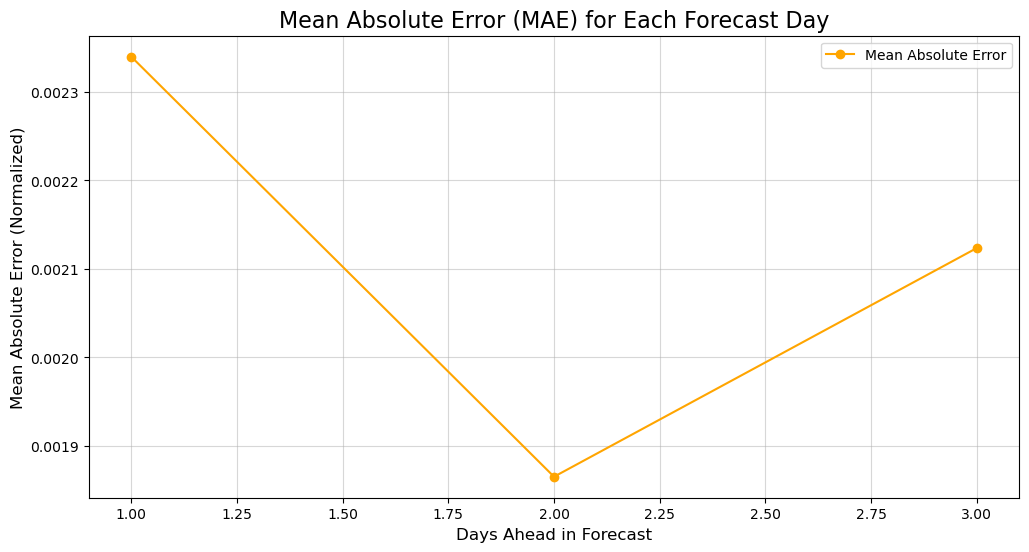

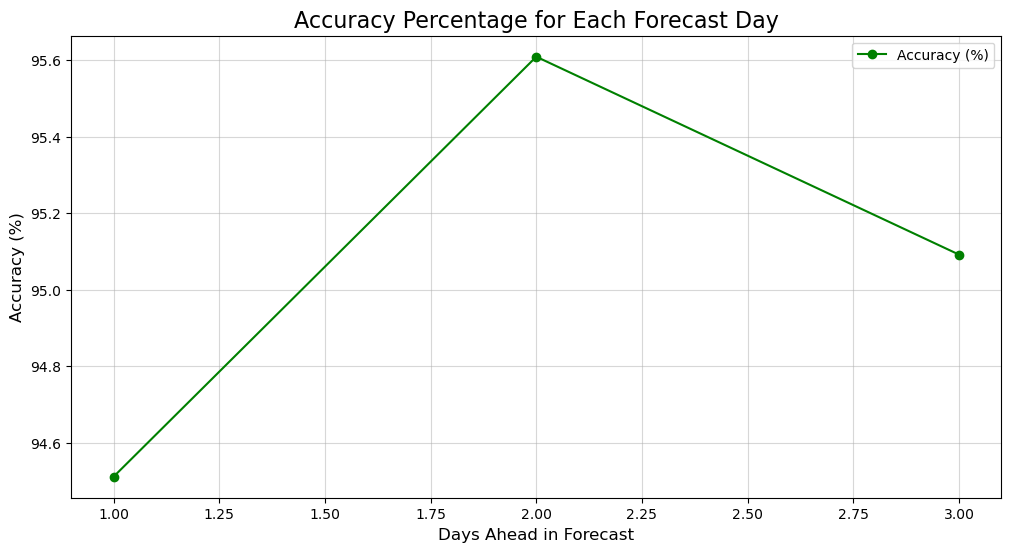

Day 1: Accuracy = 94.51%
Day 2: Accuracy = 95.61%
Day 3: Accuracy = 95.09%


In [22]:
plot_score_per_day(y_train, y_pred_train)

## Test

In [23]:
y_pred_test = model.predict([X_test_tech, X_test_fund])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [24]:
get_performance_metrics_multiple_days(y_test, y_pred_test)

{'Day 1': {'RMSE': 0.01841615851299055,
  'MAE': 0.007009540144631666,
  'R²': 0.9803718585742092,
  'NMAE': 0.08209087288225278,
  'Accuracy': 97.67441860465115,
  'MAPE': 9.919881488360888,
  'SMAPE': 11.089450449514613},
 'Day 2': {'RMSE': 0.019313181579076934,
  'MAE': 0.006618969623669398,
  'R²': 0.9787960076964887,
  'NMAE': 0.07687320389507614,
  'Accuracy': 97.67441860465115,
  'MAPE': 8.926675672998762,
  'SMAPE': 8.455232117488434},
 'Day 3': {'RMSE': 0.021448821797858498,
  'MAE': 0.0077066243012857034,
  'R²': 0.9732002793696293,
  'NMAE': 0.09036702004548289,
  'Accuracy': 96.51162790697676,
  'MAPE': 8.070039928484118,
  'SMAPE': 8.38323620724201}}

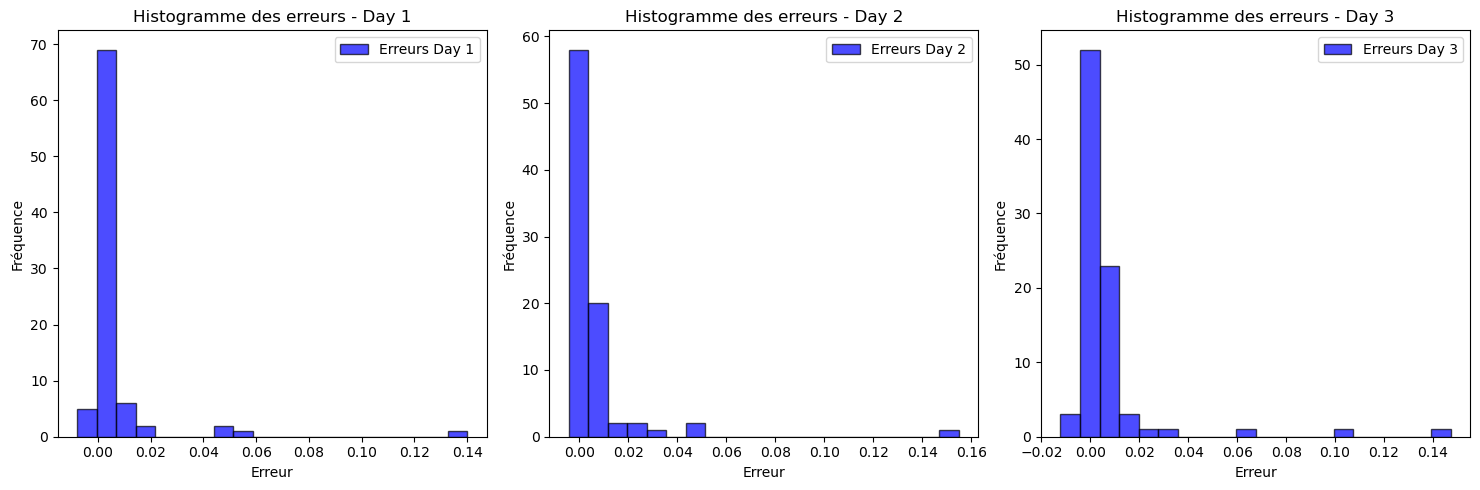

In [25]:
plot_errors_hist_multiple_days(y_test, y_pred_test)

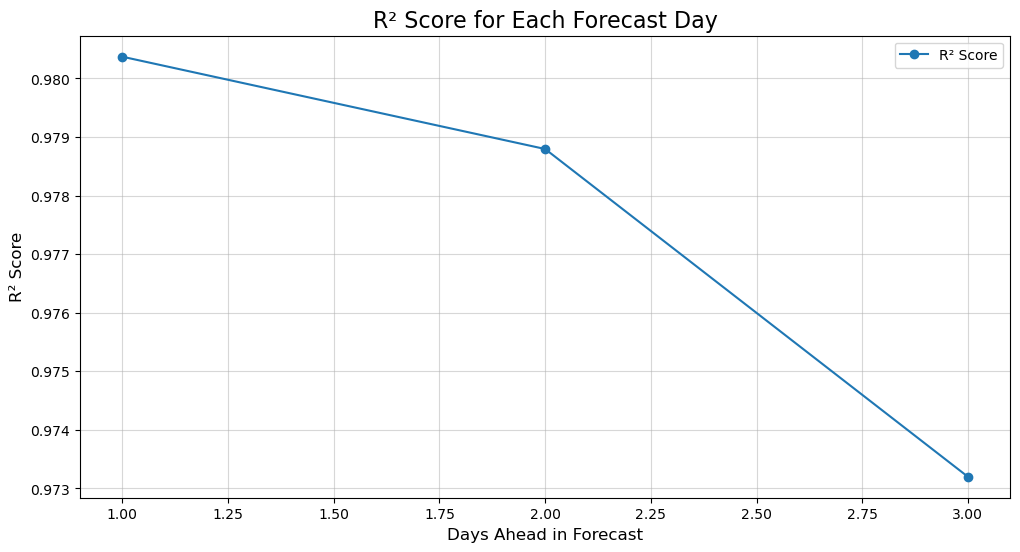

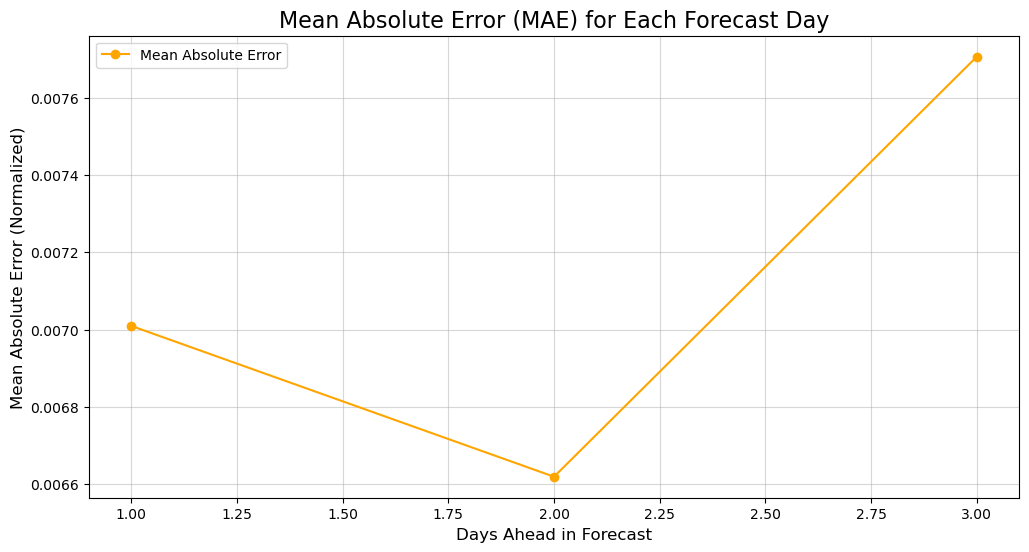

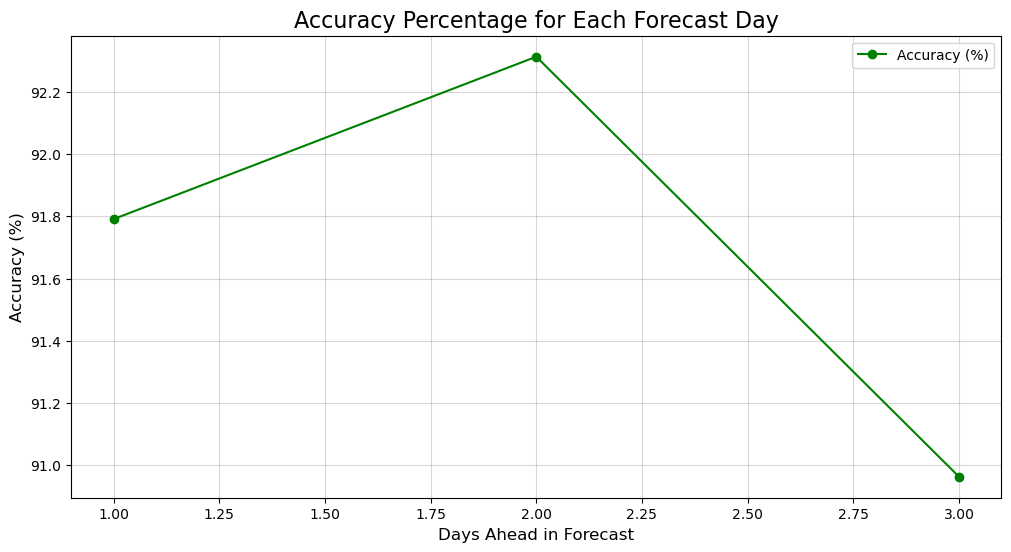

Day 1: Accuracy = 91.79%
Day 2: Accuracy = 92.31%
Day 3: Accuracy = 90.96%


In [26]:
plot_score_per_day(y_test, y_pred_test)

In [30]:
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

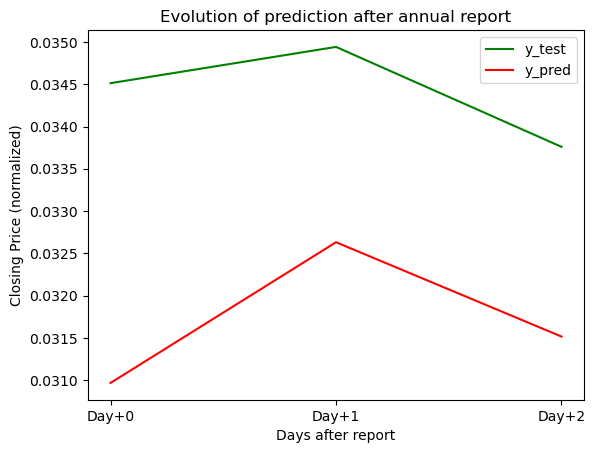

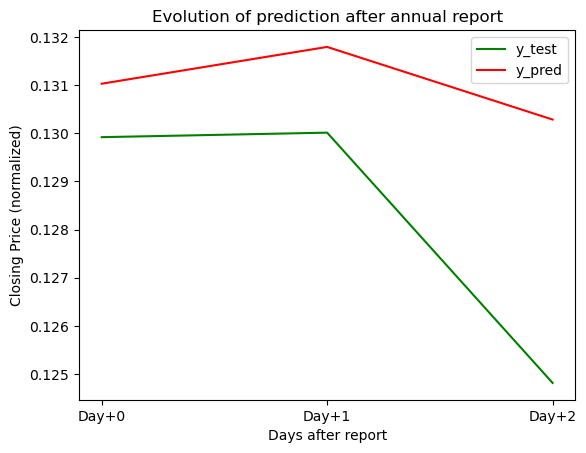

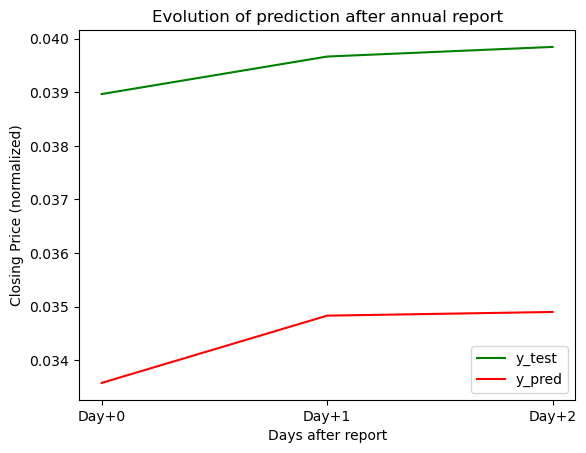

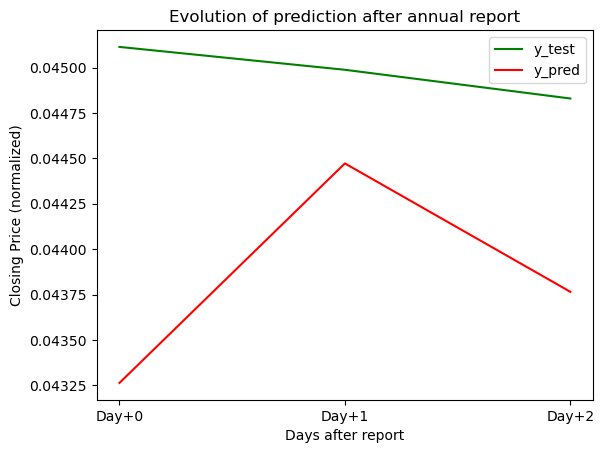

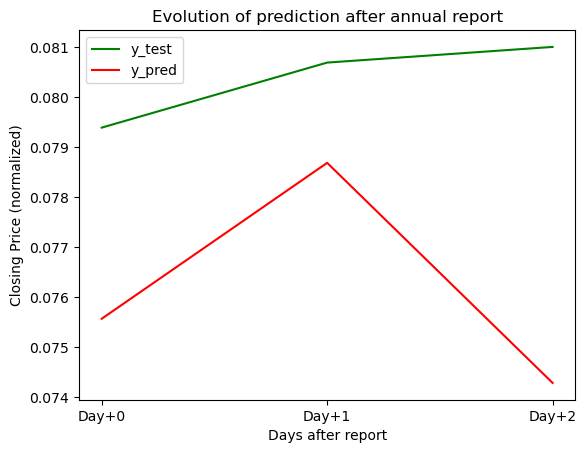

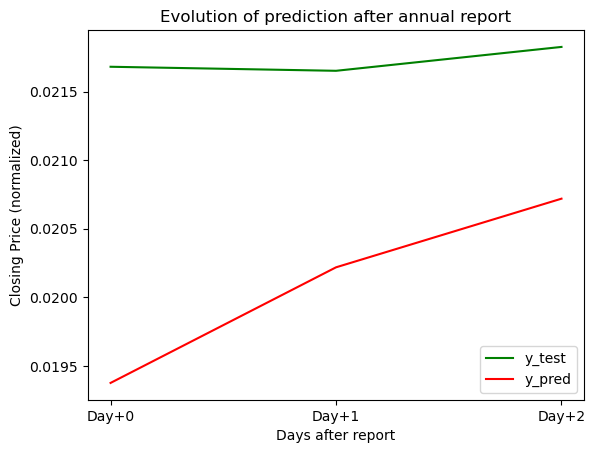

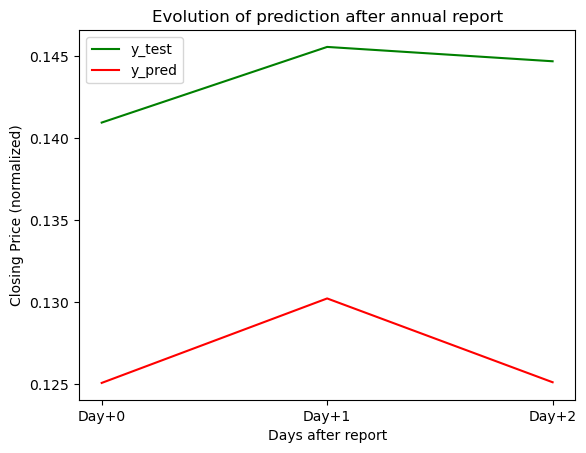

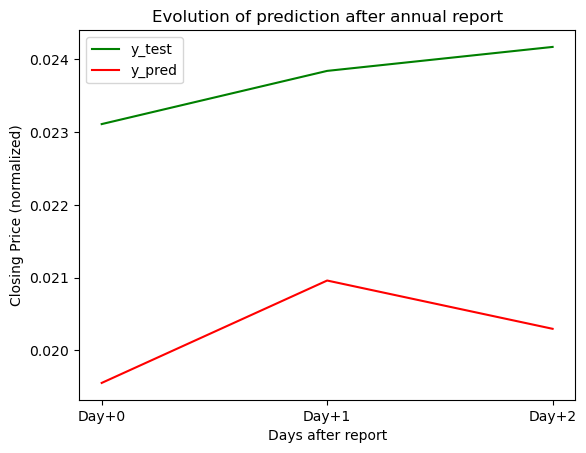

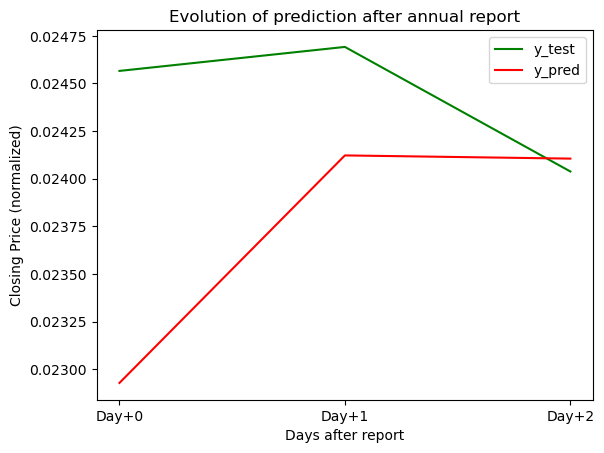

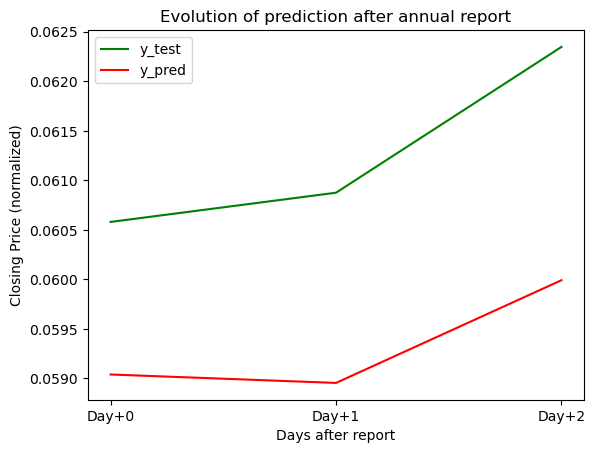

In [37]:
for i in range(10):
    plt.plot(y_test[i], color="green", label="y_test")
    plt.plot(y_pred_test[i], color="red", label="y_pred")
    plt.xlabel("Days after report")
    plt.xticks([0,1,2], ["Day+0", "Day+1", "Day+2"])
    plt.ylabel("Closing Price (normalized)")
    plt.title("Evolution of prediction after annual report")
    plt.legend()
    plt.show()